## Overcontact 
### Predikcia secondary__equivalent_radius

In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# pip install keras

     |████████████████████████████████| 1.4 MB 7.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# pip install --upgrade tensorflow

     |████████████████████████████████| 497.6 MB 2.8 kB/s  eta 0:00:01
     |████████████████████████████████| 14.5 MB 64.6 MB/s eta 0:00:01
     |████████████████████████████████| 16.8 MB 73.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 64.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 83.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 71.4 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 61.5 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.1
    Uninstalling tensorflow-2.3.1:
      Successfully uninstalled tensorflow-2.3.1
ERROR: pip's dependenc

In [2]:
from tensorflow import keras
from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
np.random.seed(1234)

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

### Data Loading

In [6]:
data = pd.read_pickle("overcontact_all_parameters.pkl").reset_index() 

In [7]:
data.head()

,index,id,curve,primary__t_eff,secondary__t_eff,inclination,mass_ratio,primary__surface_potential,secondary__surface_potential,t1/t2,filter,critical_surface_potential,primary__equivalent_radius,secondary__equivalent_radius,primary__filling_factor,secondary__filling_factor
0,0,5525038,"[0.9271109336686163, 0.9271335908185164, 0.927...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_U,1.959104,0.585781,0.21126,0.169244,0.169244
1,1,5525038,"[0.9267426667358384, 0.9267640025030627, 0.926...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_B,1.959104,0.585781,0.21126,0.169244,0.169244
2,2,5525038,"[0.9271736551553694, 0.927193188167849, 0.9272...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_V,1.959104,0.585781,0.21126,0.169244,0.169244
3,3,5525038,"[0.9286697051715368, 0.9286879105609007, 0.928...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_R,1.959104,0.585781,0.21126,0.169244,0.169244
4,4,5525038,"[0.9304596200748534, 0.9304764401089076, 0.930...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_I,1.959104,0.585781,0.21126,0.169244,0.169244


In [8]:
data_sample=data.sample(n=100000)
data_sample["filter"].value_counts()

Kepler       7839
TESS         7808
Bessell_U    7773
SLOAN_g      7764
Bessell_R    7709
SLOAN_u      7697
Bessell_V    7695
GaiaDR2      7691
Bessell_I    7665
SLOAN_r      7659
SLOAN_z      7639
SLOAN_i      7560
Bessell_B    7501
Name: filter, dtype: int64

## Data preparation and split

In [9]:
X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

y = np.array(data_sample["secondary__equivalent_radius"])

In [10]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
X_train = []
y_train = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train.append(curve[0])
        y_train.append(y_train1[i])
X_train = np.array(X_train)
y_train=np.array(y_train)

In [12]:
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(X), 
    "\nNumber of train data without noise: ", len(X_train1), 
    "\nNumber of train data with noise: ", len(X_train),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1212796 
Number of records in sample:  100000 
Number of train data without noise:  80000 
Number of train data with noise:  240000 
Number of test data without noise:  20000


### Model

In [16]:
inputs = Input(shape=(400, 1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 398, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 199, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 199, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 12736)             0         
                                                             

In [18]:
saved_model = "models/overcontact_sec_radius.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [ ]:
history = model.fit(X_train, y_train, validation_split = 0.1, epochs = 30, verbose = 1, callbacks = callbacks_list, batch_size = 64)

Epoch 1/30
3375/3375 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0478 - mape: 11.7957
Epoch 1: val_mae improved from inf to 0.03921, saving model to overcontact_sec_radius.hdf5
3375/3375 [==============================] - 368s 108ms/step - loss: 0.0053 - mae: 0.0478 - mape: 11.7957 - val_loss: 0.0028 - val_mae: 0.0392 - val_mape: 9.9100
Epoch 2/30
3375/3375 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0272 - mape: 6.4574
Epoch 2: val_mae improved from 0.03921 to 0.01844, saving model to overcontact_sec_radius.hdf5
3375/3375 [==============================] - 367s 109ms/step - loss: 0.0014 - mae: 0.0272 - mape: 6.4574 - val_loss: 5.5688e-04 - val_mae: 0.0184 - val_mape: 4.1168
Epoch 3/30
3375/3375 [==============================] - ETA: 0s - loss: 6.3928e-04 - mae: 0.0194 - mape: 4.4955
Epoch 3: val_mae did not improve from 0.01844
3375/3375 [==============================] - 367s 109ms/step - loss: 6.3928e-04 - mae: 0.0194 - mape: 4.4955 - v

In [13]:
model = load_model("models/overcontact_sec_radius.hdf5")

In [14]:
#MODEL EVALUATED ON TEST DATA WITHOUT NOISE
model.evaluate(X_test, y_test)

625/625 [==============================] - 32s 52ms/step - loss: 2.6240e-04 - mae: 0.0119 - mape: 2.7597


[0.00026240351144224405, 0.011875673197209835, 2.7596921920776367]

In [15]:
# ADD NOISE TO TEST DATA
X_test_n = []
y_test_n = []
for i in range(len(X_test)):
    for j in range(3):
        curve = stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_n.append(y_test[i])
        j += 1

In [16]:
X_test_n = np.array(X_test_n)
y_test_n = np.array(y_test_n)

In [17]:
# EVALUATED ON TEST DATA WITH NOISE
model.evaluate(X_test_n, y_test_n)

1875/1875 [==============================] - 85s 45ms/step - loss: 3.2667e-04 - mae: 0.0132 - mape: 3.0800


[0.0003266650310251862, 0.01318399515002966, 3.0799832344055176]

## Prediction on test data - without noise

In [18]:
y_pred = model.predict(X_test)

In [24]:
y_pred = np.reshape(y_pred, len(y_pred))
df = pd.DataFrame(data = {'y_test': y_test, 'y_predict': y_pred})
df["diff"] = df["y_test"]-df["y_predict"]
df["abs_diff"] = abs(df["diff"])
df["relative_error"] = df["abs_diff"] / df["y_test"]
df.head()

     y_test  y_predict      diff  abs_diff  relative_error
0  0.492100   0.525408 -0.033308  0.033308        0.067685
1  0.471755   0.513581 -0.041826  0.041826        0.088659
2  0.406935   0.403672  0.003262  0.003262        0.008017
3  0.477260   0.485887 -0.008627  0.008627        0.018076
4  0.257956   0.233153  0.024803  0.024803        0.096151
Min relative error:  2.1909429004788953e-06
Max relative error:  0.6923777022077179


In [ ]:
print("Min relative error: ", min(df.relative_error))
print("Max relative error: ", max(df.relative_error))

In [20]:
df_mean = df.groupby(["y_test"])
df_mean = pd.DataFrame(df_mean.relative_error.mean()).reset_index()
a = df_mean.y_test.array.astype(str)
b = df_mean.relative_error.array
df_mean.head()

,y_test,relative_error
0,0.211260,0.144736
1,0.230923,0.115494
2,0.257956,0.071525
3,0.276516,0.050343
4,0.284784,0.051738


C:\Users\nemci\AppData\Local\Temp\ipykernel_13948\2040457017.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b="on")


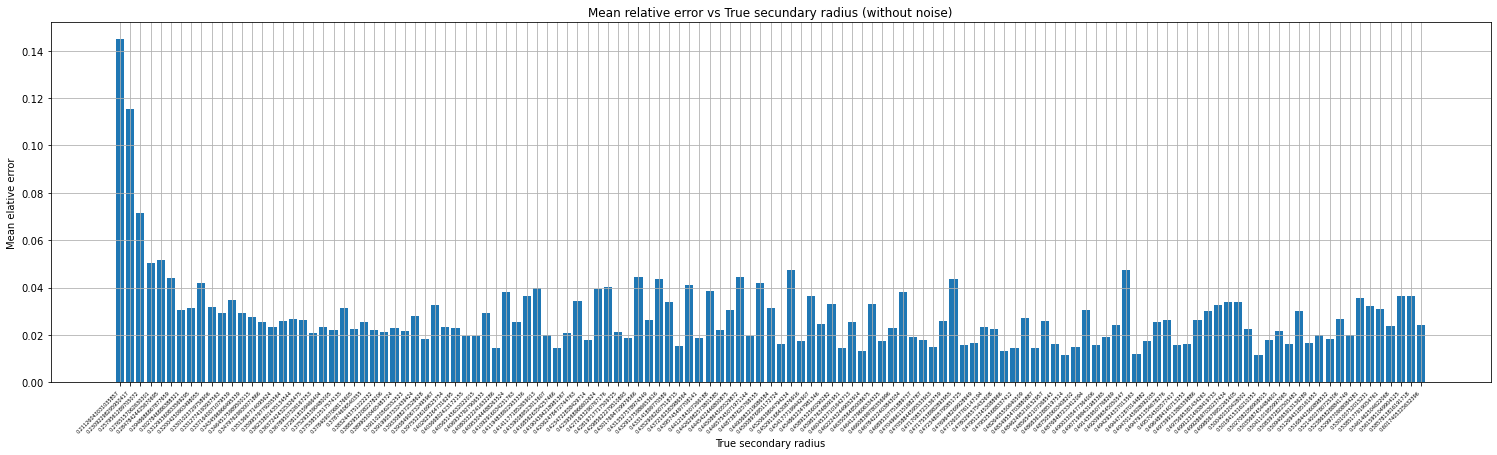

In [26]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
true = a
rel = b
ax.bar(true, rel)
ax.set_ylabel("Mean elative error")
ax.set_xlabel("True secondary radius")
ax.set_title("Mean relative error vs True secondary radius (without noise)")
plt.xticks(rotation=45, ha='right', fontsize = 5)
plt.grid(b="on")

plt.show()

## Comparison of true and predicted values - synthetic test data without noise

In [27]:
# Sample of true and predicted values
# true_sample = y_test[0:50]
# pred_sample = y_pred[0:50]
idx = np.random.choice(np.arange(len(y_test)), 50, replace=False)
true_sample = y_test[idx]
pred_sample = y_pred[idx]

In [28]:
comp = pd.DataFrame(data={"true_radius": true_sample,
                        "predicted_radius": pred_sample})
comp["diff"] = comp.true_radius - comp.predicted_radius
comp["abs_diff"] = abs(comp["diff"])
comp["relative_error"] = comp["abs_diff"]/comp["true_radius"]
comp.head()

,true_radius,predicted_radius,diff,abs_diff,relative_error
0,0.337164,0.361147,-0.023983,0.023983,0.071131
1,0.449368,0.458136,-0.008768,0.008768,0.019511
2,0.389905,0.405777,-0.015871,0.015871,0.040706
3,0.454178,0.472534,-0.018357,0.018357,0.040418
4,0.485654,0.474450,0.011204,0.011204,0.023071


C:\Users\nemci\AppData\Local\Temp\ipykernel_13948\1455540349.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b="on")


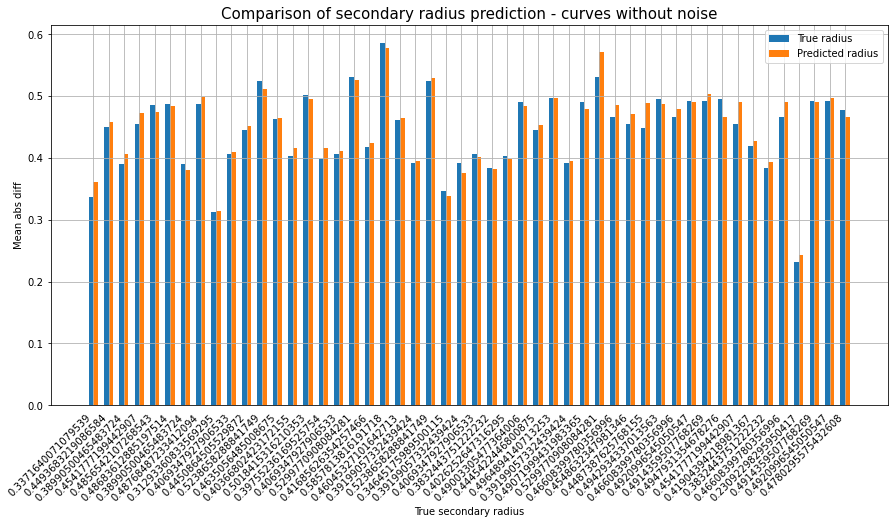

In [30]:
fig, ax = plt.subplots(figsize=(15,7))
x = np.arange(len(comp))
width = 0.3
plt.bar(x-0.15, comp.true_radius, width, label='True radius')
plt.bar(x+0.15, comp.predicted_radius, width, label='Predicted radius')
plt.title('Comparison of secondary radius prediction - curves without noise', fontsize=15)
plt.xticks(x, comp.true_radius, rotation=45, ha='right')
ax.set_ylabel("Mean abs diff")
ax.set_xlabel("True secondary radius")
ax.grid(False)
ax.tick_params(bottom=False, left=True)
plt.legend()
plt.grid(b="on")
plt.show()

## Prediction on test data with noise

In [31]:
y_pred_n=model.predict(X_test_n)

In [32]:
y_pred_n = np.reshape(y_pred_n, len(y_pred_n))
df_n = pd.DataFrame(data = {'y_test_n': y_test_n, 'y_predict_n': y_pred_n})
df_n["diff"] = df_n["y_test_n"]-df_n["y_predict_n"]
df_n["abs_diff"] = abs(df_n["diff"])
df_n["relative_error"] = df_n["abs_diff"]/df_n["y_test_n"]
df_n.head()

,y_test_n,y_predict_n,diff,abs_diff,relative_error
0,0.492100,0.525714,-0.033615,0.033615,0.068309
1,0.492100,0.543207,-0.051108,0.051108,0.103856
2,0.492100,0.525355,-0.033255,0.033255,0.067577
3,0.471755,0.533294,-0.061539,0.061539,0.130446
4,0.471755,0.519853,-0.048098,0.048098,0.101955


In [33]:
df_mean_n = df_n.groupby(["y_test_n"])
df_mean_n = pd.DataFrame(df_mean_n.relative_error.mean()).reset_index()
a_n = df_mean_n.y_test_n.array.astype(str)
b_n = df_mean_n.relative_error.array
df_mean_n.head()

,y_test_n,relative_error
0,0.211260,0.165808
1,0.230923,0.122678
2,0.257956,0.080512
3,0.276516,0.057042
4,0.284784,0.062754


C:\Users\nemci\AppData\Local\Temp\ipykernel_13948\1940433400.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b="on")


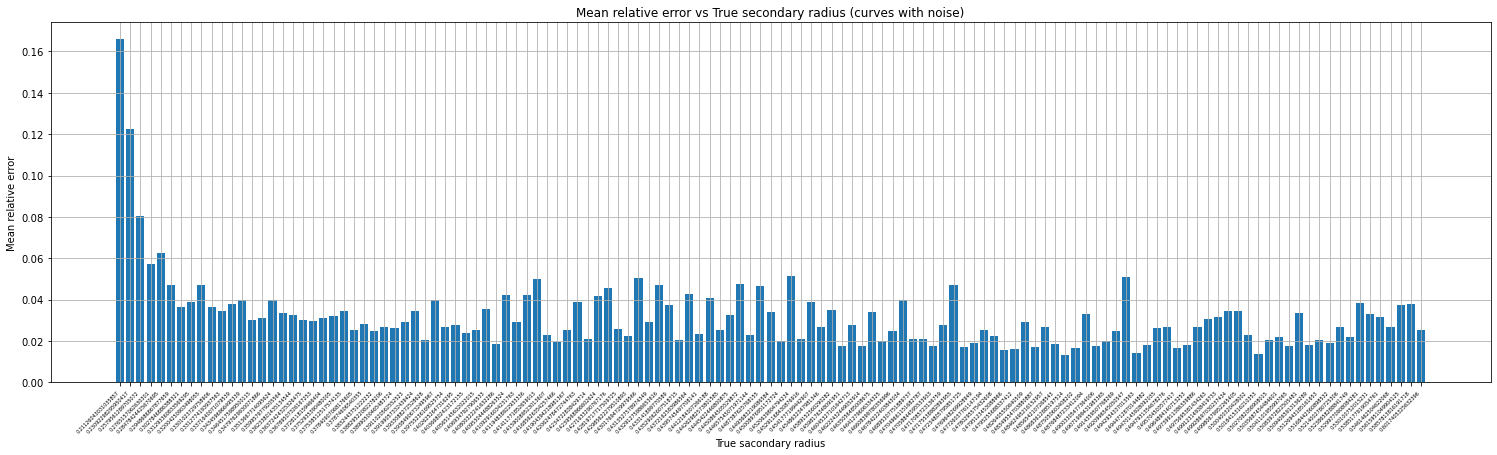

In [35]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
true = a_n
mean = b_n
ax.bar(true, mean)
ax.set_ylabel("Mean relative error")
ax.set_xlabel("True secondary radius")
ax.set_title("Mean relative error vs True secondary radius (curves with noise)")
plt.xticks(rotation=45, ha='right', fontsize = 5)
plt.grid(b="on")

plt.show()

## Comparison of true and predicted values - test data with noise

In [36]:
# Sample of true and predicted values
# true_sample_n = y_test_n[0:50]
# pred_sample_n = y_pred_n[0:50]
idx = np.random.choice(np.arange(len(y_test_n)), 50, replace=False)
true_sample_n = y_test_n[idx]
pred_sample_n = y_pred_n[idx]

In [37]:
comp_n = pd.DataFrame(data={"true_radius": true_sample_n,
                        "predicted_radius": pred_sample_n})
comp_n["diff"] = comp_n.true_radius - comp_n.predicted_radius
comp_n["abs_diff"] = abs(comp_n["diff"])
comp_n["relative_error"] = comp_n["abs_diff"]/comp_n["true_radius"]
comp_n.head()

,true_radius,predicted_radius,diff,abs_diff,relative_error
0,0.508397,0.502724,0.005673,0.005673,0.011159
1,0.467842,0.475781,-0.007938,0.007938,0.016968
2,0.471755,0.509014,-0.037259,0.037259,0.078979
3,0.472348,0.476056,-0.003708,0.003708,0.007850
4,0.509407,0.492804,0.016603,0.016603,0.032592


C:\Users\nemci\AppData\Local\Temp\ipykernel_13948\972057078.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b="on")


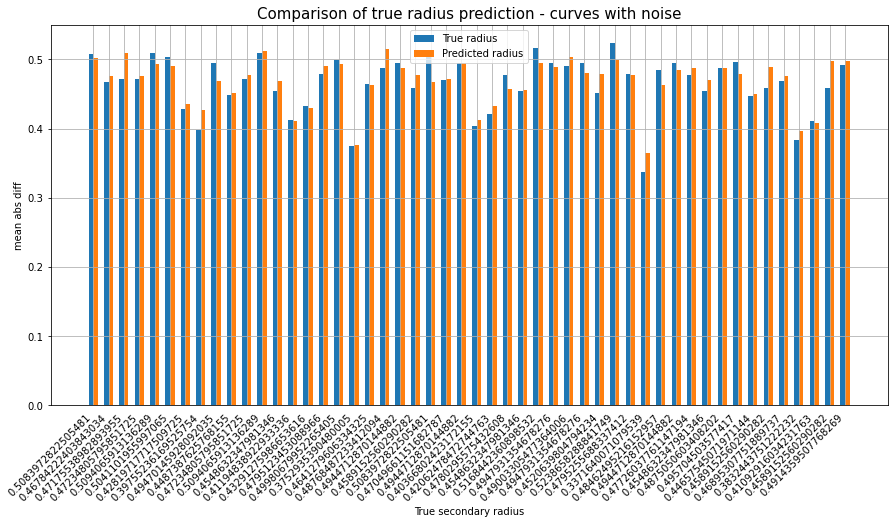

In [38]:
fig, ax = plt.subplots(figsize=(15,7))
x = np.arange(len(comp_n))
width = 0.3
plt.bar(x-0.15, comp_n.true_radius, width, label='True radius')
plt.bar(x+0.15, comp_n.predicted_radius, width, label='Predicted radius')
plt.title('Comparison of true radius prediction - curves with noise', fontsize=15)
plt.xticks(x, comp_n.true_radius, rotation=45, ha='right')
ax.set_ylabel("mean abs diff")
ax.set_xlabel("True secondary radius")
ax.grid(False)
ax.tick_params(bottom=False, left=True)
plt.legend()
plt.grid(b="on")
plt.show()